In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "5

In [2]:
import torch

In [18]:
x = torch.zeros((22, 4, 1))
y = torch.zeros((22, 4, 1))
z = torch.zeros((22,4,1))
gamma = 1

focal_loss = (x * (1-y)**gamma * z).mean() # mean over the batch

In [20]:
x = torch.Tensor([11,23,12])
y = torch.Tensor([0,1,1,0,2,1,1,1])
x[y]

IndexError: tensors used as indices must be long, byte or bool tensors

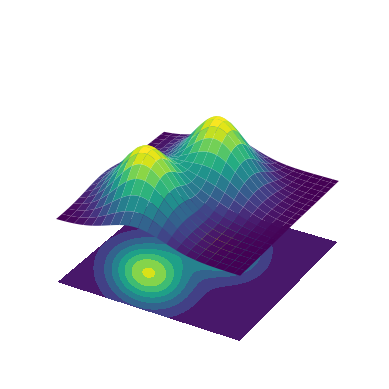

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from   matplotlib import cm
from   mpl_toolkits.mplot3d import Axes3D
from   scipy.stats import multivariate_normal

# Our 2-dimensional distribution will be over variables X and Y
N = 60
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 4, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([-1., -1.])
Sigma = np.array([[ 1. , -0.5], [-0.5,  1.5]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

# The distribution on the variables X, Y packed into pos.
F = multivariate_normal(mu, Sigma)
Z = F.pdf(pos)

# Mean vector and covariance matrix
mu_2 = np.array([-0.1, 2])
Sigma_2 = np.array([[ 1. , +0.5], [-0.5,  1.5]])

# Pack X and Y into a single 3-dimensional array
pos_2 = np.empty(X.shape + (2,))
pos_2[:, :, 0] = X
pos_2[:, :, 1] = Y

# The distribution on the variables X, Y packed into pos.
F_2 = multivariate_normal(mu_2, Sigma_2)
Z_2 = F_2.pdf(pos_2)

Z = Z + Z_2
# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
#ax.view_init(27, -21)

ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_axis_off()

plt.show()

In [4]:
from memflow.read_data.dataset_all import DatasetCombined

from utils import alter_variables
from utils import alter_variables_tensor
import math

import numpy as np
import scipy.stats as st
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib import cm

from tensorboardX import SummaryWriter
from omegaconf import OmegaConf
import sys
import argparse
import os
from pynvml import *
from hist import Hist
import hist
import vector
import mplhep
import awkward as ak

from utils import FindMasks
from utils import SavePlots
from utils import plot_regressionFactor

from matplotlib.colors import ListedColormap
import pandas as pd

pi = torch.pi

torch.set_num_threads(10)

In [5]:
batchSize = 128

device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')
        
model_dir = '/eos/user/a/adpetre/www/ttHbbAnalysis/MEMFlow/models_archive/classifier_nojets_train_v1/Classifier_noJets_classifier_nojets_v1 weighted_hiddenFeature_64_numLayers_6'
path_to_conf = model_dir + '/config_classifier_nojets_v1 weighted.yaml'
path_to_model = model_dir + '/model_classifier_nojets_v1 weighted.pt'


with open(path_to_conf) as f:
        config = OmegaConf.load(path_to_conf)

In [6]:
path_data = config.input_dataset_train
#path_data = config.input_dataset_validation
#path_data = config.input_dataset_test
print(path_data)

test_data = DatasetCombined(path_data, dev=device, datasets=["partons_lab", "reco_lab"], build=False,
                            dtype=torch.float64,
                            reco_list_lab=['mask_jets'],
                            parton_list_lab=["data_higgs_t_tbar_ISR"])

/eos/user/a/adpetre/www/ttHbbAnalysis/training_dataset/v3_sig_forTrainingDataset/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_train.parquet
>>Loading datasets
Loading partons in LAB
PartonLevel LAB
Reading parton_level Files
Parton: Move tensors to device (cuda) memory


/home/user/micromamba/lib/python3.9/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Loading reco in LAB
RecoLevel LAB
Reading reco_level Files
Reco: Move tensors to device (cuda) memory
Loaded datasets:  ['partons_lab', 'reco_lab']


In [7]:
noJets = torch.count_nonzero(test_data.reco_lab.mask_jets, dim=1)
partons = test_data.partons_lab.data_higgs_t_tbar_ISR

print(noJets.shape)
print(partons.shape)

torch.Size([1612912])
torch.Size([1612912, 4, 4])


In [8]:
pt_bins = [30,50,75,100,125,150,175,200,250,300,400,500,750,1000]
eta_bins = [-5,-4,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,4,5]
phi_bins = [-3.2,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3.2]

noJets_bins = [i+4 for i in range(13)]
print(noJets_bins)

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


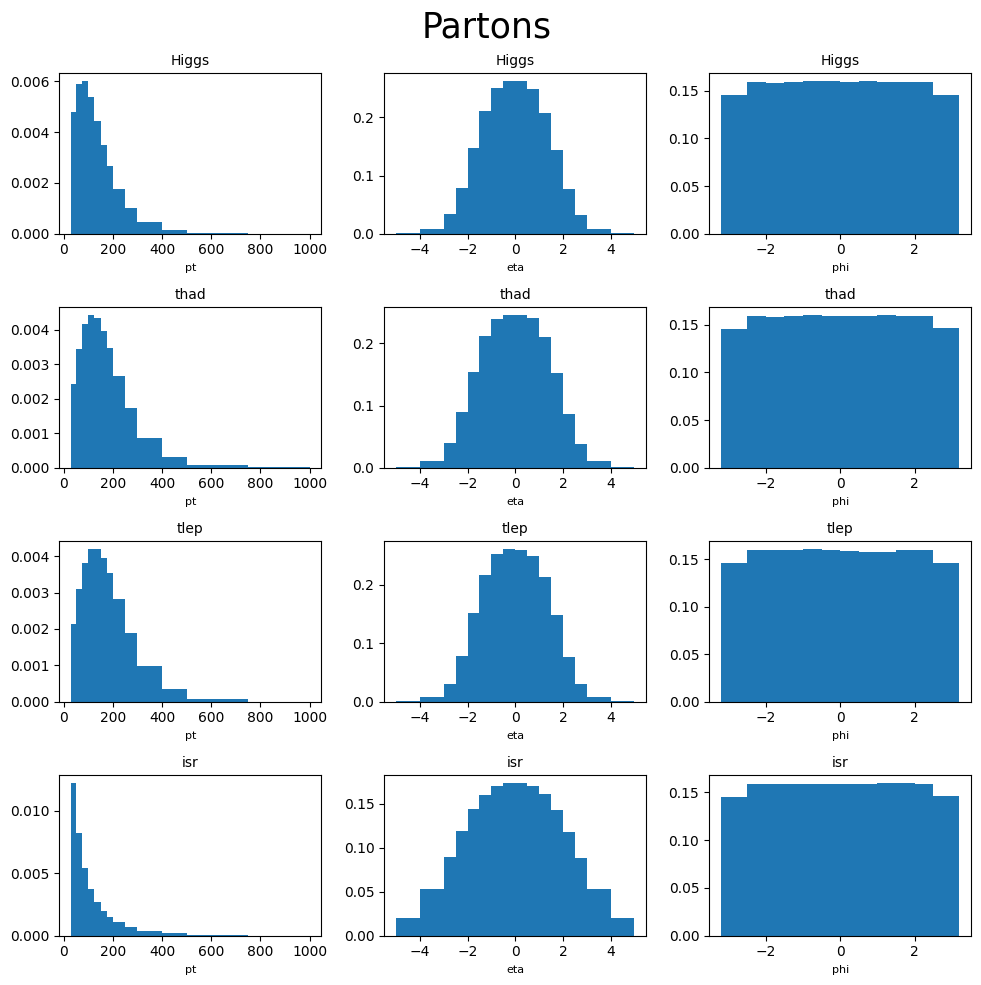

In [12]:
no_plots_1 = 4
no_plots_2 = 3
labels = ['pt','eta','phi']
particles = ['Higgs', 'thad', 'tlep', 'isr']

fig, ax = plt.subplots(no_plots_1, no_plots_2, figsize=(10, 10))
fig.suptitle('Partons', fontsize=25)

for particle in range(4):
    for feature in range(3):
        if feature == 0:
            bins = pt_bins
        elif feature == 1:
            bins = eta_bins
        else:
            bins = phi_bins
        _ = ax[particle, feature].hist(partons[:,particle,feature].cpu().numpy(), bins=bins, density=True)

        ax[particle, feature].set_title(f'{particles[particle]}', fontsize=10)
        ax[particle, feature].set_xlabel(labels[feature], fontsize=8)
    
plt.tight_layout()

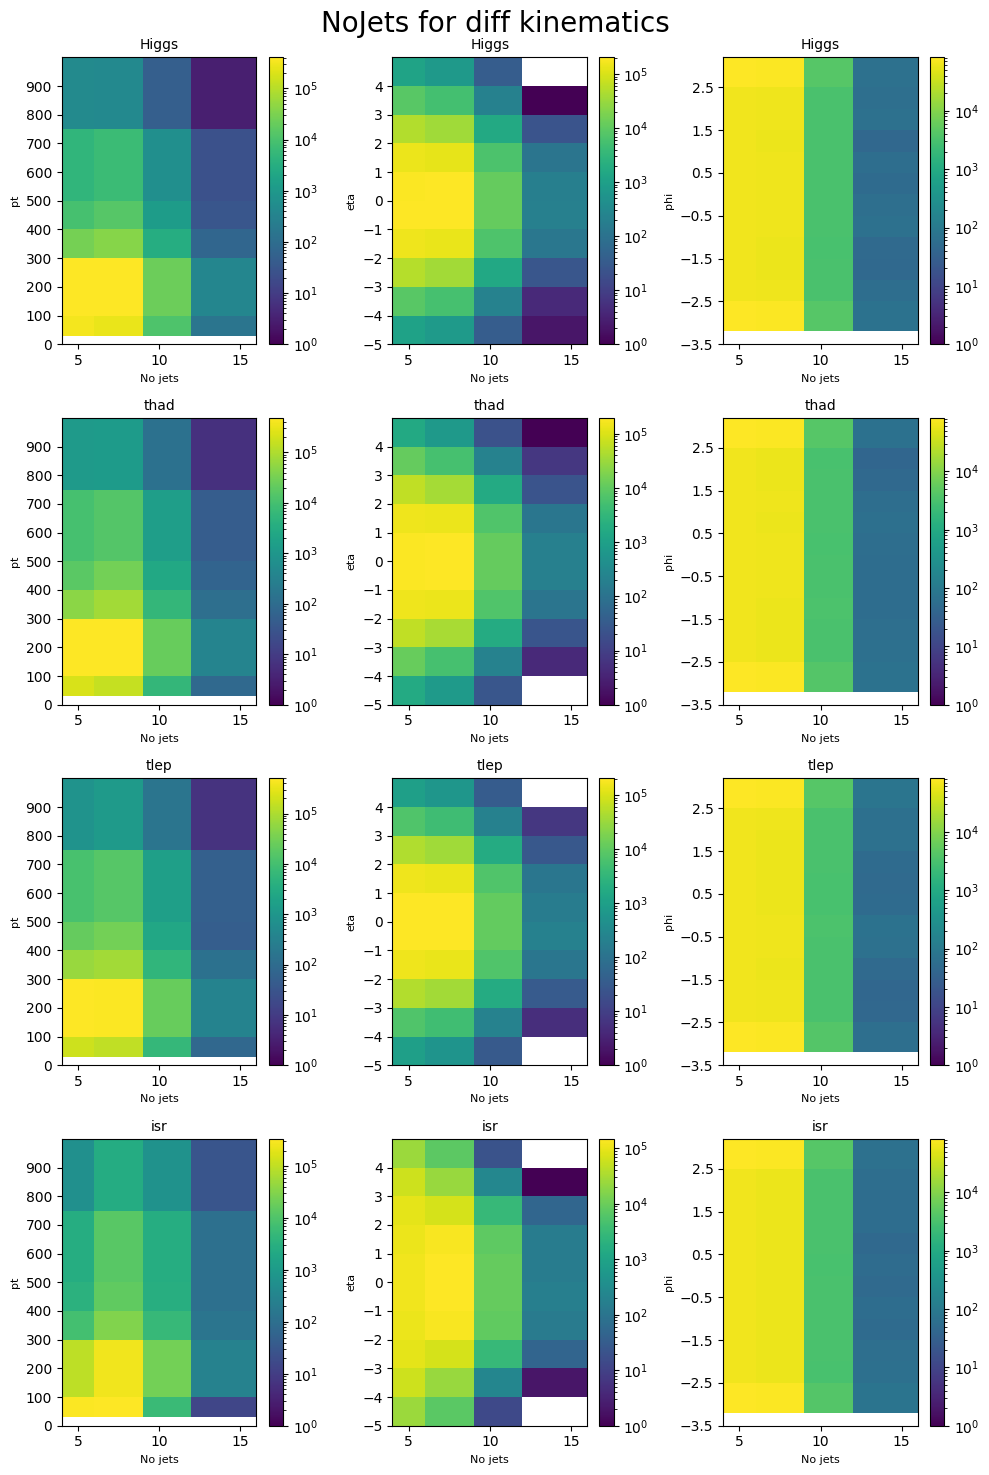

In [13]:
pt_bins = [30,100,300,400,500,750,1000]
eta_bins = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
phi_bins = [-3.2,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3.2]
noJets_bins = [4,6,9,12,16]

no_plots_1 = 4
no_plots_2 = 3
labels = ['pt','eta','phi']
particles = ['Higgs', 'thad', 'tlep', 'isr']
colormap='viridis'
my_viridis = mpl.colormaps[colormap].with_extremes(under="white")

fig, ax = plt.subplots(no_plots_1, no_plots_2, figsize=(10, 15))
fig.suptitle('NoJets for diff kinematics', fontsize=20)

for particle in range(4):
    for feature in range(3):
        if feature == 0:
            bins = pt_bins
            start = 0
            end = 1000
            step = 100
        elif feature == 1:
            bins = eta_bins
            start = -5
            end = 5
            step = 1
        else:
            bins = phi_bins
            start = -3.5
            end = 3.5
            step = 1
        #hist = ax[particle, feature].hist2d(partons[:,particle,feature].cpu().numpy(), noJets.cpu().numpy(), bins=[bins, noJets_bins],
        #                                    norm=mpl.colors.LogNorm(vmin=1), cmap=my_viridis)
        hist = ax[particle, feature].hist2d(noJets.cpu().numpy(), partons[:,particle,feature].cpu().numpy(),
                                            bins=[noJets_bins, bins],
                                            norm=mpl.colors.LogNorm(vmin=1), cmap=my_viridis)
        
        cb1=plt.colorbar(hist[3], ax=ax[particle, feature])
        
        ax[particle, feature].set_title(f'{particles[particle]}', fontsize=10)
        ax[particle, feature].set_xlabel('No jets', fontsize=8)
        ax[particle, feature].set_ylabel(labels[feature], fontsize=8)
        
        ax[particle, feature].set_yticks(np.arange(start, end, step))
        #ax[particle, feature].set_yticklabels(ax[particle, feature].get_yticks(), rotation=60)
    
plt.tight_layout()

# Get central events with ISR (all particles to have abs(eta) < 1)

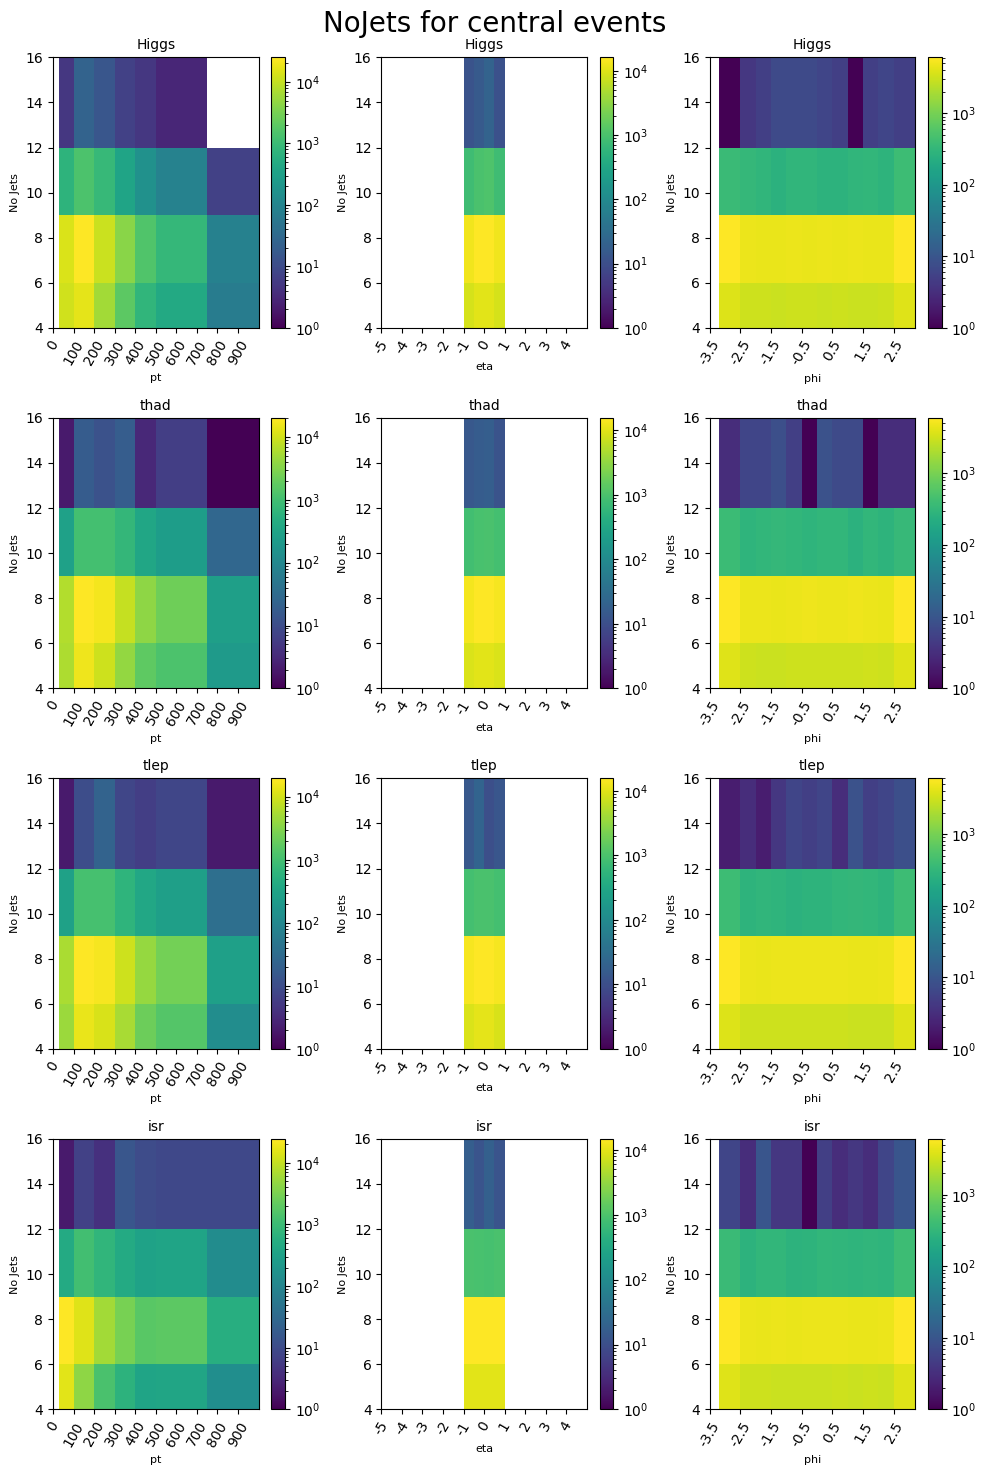

In [14]:
# with ISR
central_eta_mask = partons[:,:,1] > -1
central_eta_mask2 = partons[:,:,1] < 1

central_mask = torch.logical_and(central_eta_mask, central_eta_mask2)
events_mask = torch.count_nonzero(central_mask, dim=1) == 4

pt_bins = [30,100,200,300,400,500,750,1000]
eta_bins = [-5,-4,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,4,5]
phi_bins = [-3.2,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3.2]

no_plots_1 = 4
no_plots_2 = 3
labels = ['pt','eta','phi']
particles = ['Higgs', 'thad', 'tlep', 'isr']
colormap='viridis'
my_viridis = mpl.colormaps[colormap].with_extremes(under="white")

fig, ax = plt.subplots(no_plots_1, no_plots_2, figsize=(10, 15))
fig.suptitle('NoJets for central events', fontsize=20)

for particle in range(4):
    for feature in range(3):
        if feature == 0:
            bins = pt_bins
            start = 0
            end = 1000
            step = 100
        elif feature == 1:
            bins = eta_bins
            start = -5
            end = 5
            step = 1
        else:
            bins = phi_bins
            start = -3.5
            end = 3.5
            step = 1
        hist = ax[particle, feature].hist2d(partons[events_mask,particle,feature].cpu().numpy(),
                                            noJets[events_mask].cpu().numpy(), bins=[bins, noJets_bins],
                                            norm=mpl.colors.LogNorm(vmin=1), cmap=my_viridis)
        
        cb1=plt.colorbar(hist[3], ax=ax[particle, feature])
        
        ax[particle, feature].set_title(f'{particles[particle]}', fontsize=10)
        ax[particle, feature].set_xlabel(labels[feature], fontsize=8)
        ax[particle, feature].set_ylabel('No Jets', fontsize=8)
        
        ax[particle, feature].set_xticks(np.arange(start, end, step))
        ax[particle, feature].set_xticklabels(ax[particle, feature].get_xticks(), rotation=60)
    
plt.tight_layout()

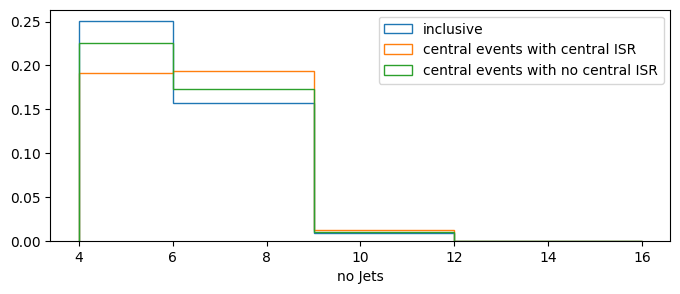

In [15]:
# with ISR
central_eta_mask = partons[:,:,1] > -1
central_eta_mask2 = partons[:,:,1] < 1

central_mask = torch.logical_and(central_eta_mask, central_eta_mask2)
events_mask = torch.count_nonzero(central_mask, dim=1) == 4

# without ISR
central_eta_mask = partons[:,:3,1] > -1
central_eta_mask2 = partons[:,:3,1] < 1

central_mask_noISR = torch.logical_and(central_eta_mask, central_eta_mask2)
events_mask_noISR = torch.count_nonzero(central_mask_noISR, dim=1) == 3

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
freq, _, _ = ax.hist(noJets.cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label='inclusive')
freq_centralEvent, _, _ = ax.hist(noJets[events_mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label='central events with central ISR')
freq_centralEvent_noISR, _, _ = ax.hist(noJets[events_mask_noISR].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label='central events with no central ISR')
ax.set_xlabel('no Jets')
ax.legend()

/afs/cern.ch/user/a/adpetre/.local/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


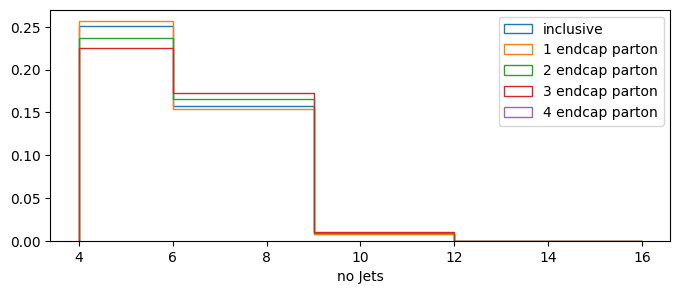

In [16]:
endcap_eta_mask = torch.abs(partons[:,:,1]) > 3
endcap_mask_1 = torch.count_nonzero(central_mask_noISR, dim=1) == 1
endcap_mask_2 = torch.count_nonzero(central_mask_noISR, dim=1) == 2
endcap_mask_3 = torch.count_nonzero(central_mask_noISR, dim=1) == 3
endcap_mask_4 = torch.count_nonzero(central_mask_noISR, dim=1) == 4

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.hist(noJets.cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label='inclusive')
ax.hist(noJets[endcap_mask_1].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label='1 endcap parton')
ax.hist(noJets[endcap_mask_2].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label='2 endcap parton')
ax.hist(noJets[endcap_mask_3].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label='3 endcap parton')
ax.hist(noJets[endcap_mask_4].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label='4 endcap parton')
ax.set_xlabel('no Jets')
ax.legend()

8


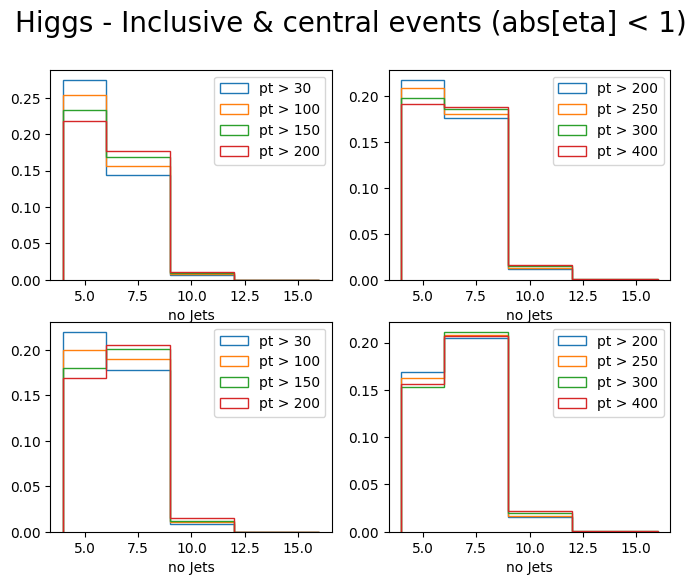

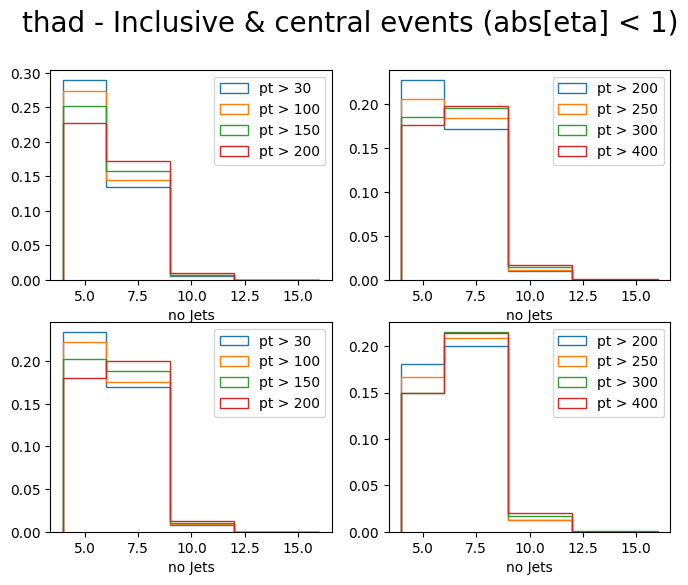

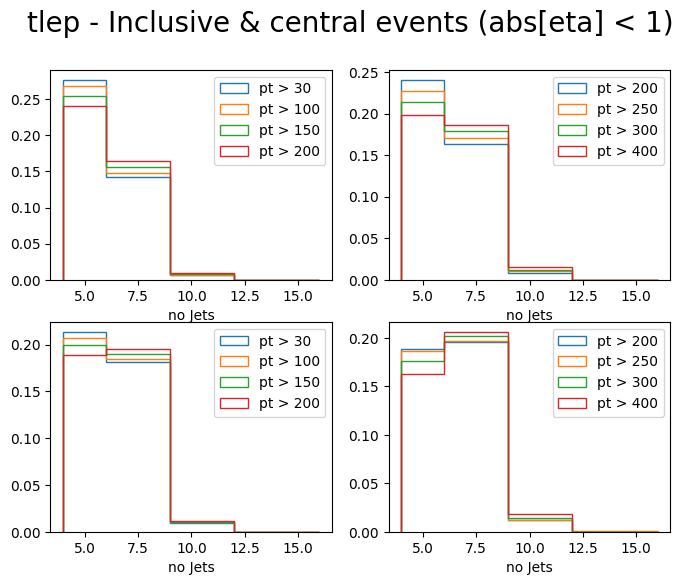

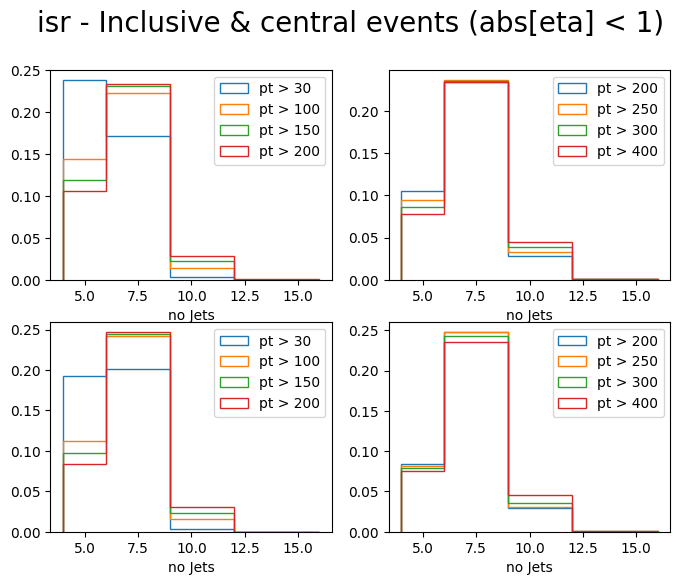

In [17]:
particles = ['Higgs', 'thad', 'tlep', 'isr']
no_plots = int(len(pt_bins)/4)
print(len(pt_bins))
pt_bins = [30,100,150,200,250,300,400,500,1000]
central_partons = partons[events_mask]

# particle pt
for particle in range(4):

    fig, ax = plt.subplots(2, no_plots, figsize=(8, 6))
    fig.suptitle(f'{particles[particle]} - Inclusive & central events (abs[eta] < 1)', fontsize=20)

    particle_pt = partons[:,particle,0]
    for i in range(4):
        mask_1 = particle_pt > pt_bins[i]
        mask_2 = particle_pt < pt_bins[i + 1]
        mask = torch.logical_and(mask_1, mask_2)
        ax[0,0].hist(noJets[mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label=f'pt > {pt_bins[i]}')
        
        # AND between mask And central events
        mask = torch.logical_and(mask, events_mask)
        ax[1,0].hist(noJets[mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label=f'pt > {pt_bins[i]}')

    ax[0,0].set_xlabel('no Jets')
    ax[0,0].legend()
    ax[1,0].set_xlabel('no Jets')
    ax[1,0].legend()

    last_var = i
    for i in range(4):
        mask_1 = particle_pt > pt_bins[last_var + i]
        mask_2 = particle_pt < pt_bins[last_var + i + 1]
        mask = torch.logical_and(mask_1, mask_2)
        ax[0,1].hist(noJets[mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step',
                   label=f'pt > {pt_bins[last_var + i]}')
        
        # AND between mask And central events
        mask = torch.logical_and(mask, events_mask)
        ax[1,1].hist(noJets[mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step',
                   label=f'pt > {pt_bins[last_var + i]}')

    ax[0,1].set_xlabel('no Jets')
    ax[0,1].legend()
    ax[1,1].set_xlabel('no Jets')
    ax[1,1].legend()

9


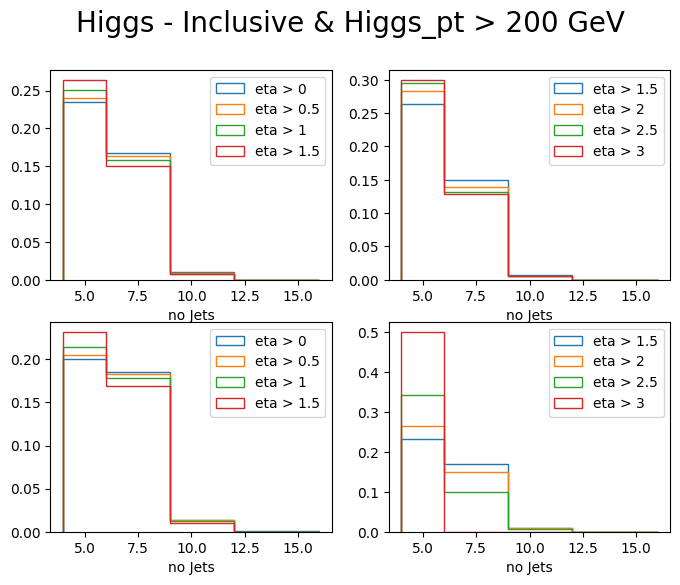

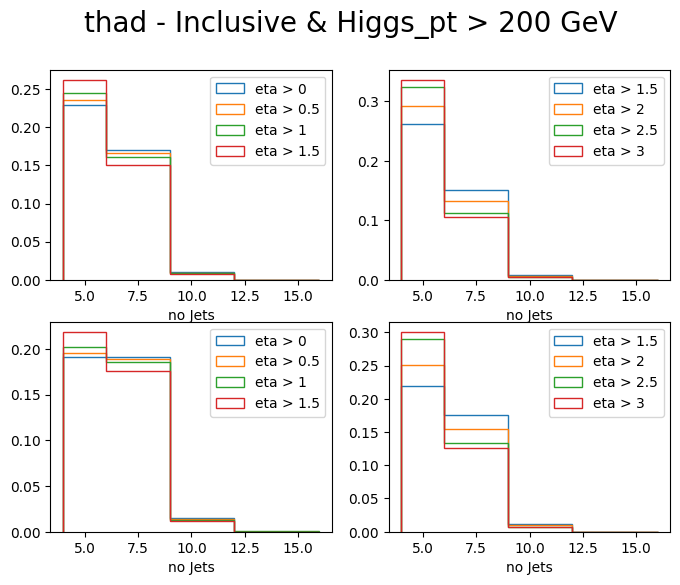

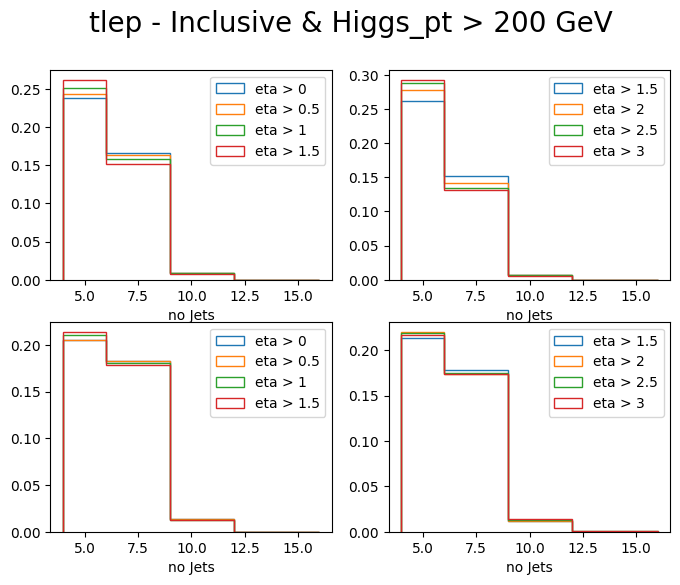

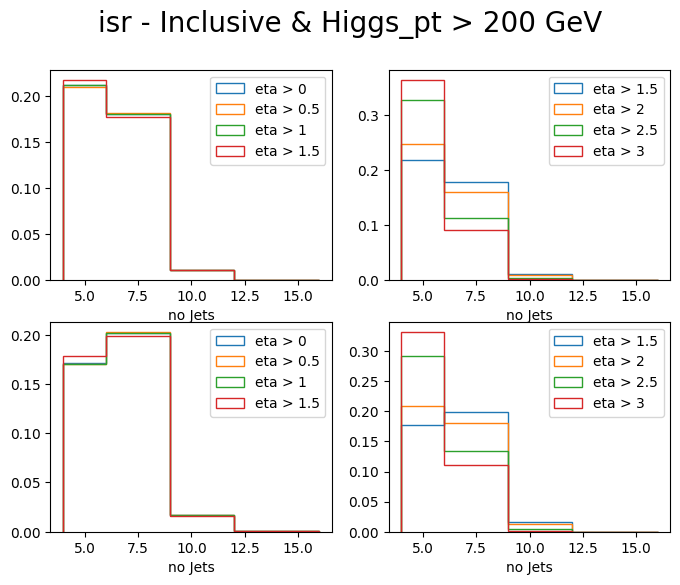

In [18]:
particles = ['Higgs', 'thad', 'tlep', 'isr']
no_plots = int(len(pt_bins)/4)
print(len(pt_bins))
eta_bins = [0,0.5,1,1.5,2,2.5,3,5]

events_HiggsPtLarger200 = partons[:,0,0] > 200

# particle pt
for particle in range(4):

    fig, ax = plt.subplots(2, no_plots, figsize=(8, 6))
    fig.suptitle(f'{particles[particle]} - Inclusive & Higgs_pt > 200 GeV', fontsize=20)

    particle_eta = torch.abs(partons[:,particle,1])
    for i in range(4):
        mask_1 = particle_eta > eta_bins[i]
        mask_2 = particle_eta < eta_bins[i + 1]
        mask = torch.logical_and(mask_1, mask_2)
        ax[0,0].hist(noJets[mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label=f'eta > {eta_bins[i]}')
        
        # AND between mask And central events
        mask = torch.logical_and(mask, events_HiggsPtLarger200)
        ax[1,0].hist(noJets[mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label=f'eta > {eta_bins[i]}')

    ax[0,0].set_xlabel('no Jets')
    ax[0,0].legend()
    ax[1,0].set_xlabel('no Jets')
    ax[1,0].legend()

    last_var = i
    for i in range(4):
        mask_1 = particle_eta > eta_bins[last_var + i]
        mask_2 = particle_eta < eta_bins[last_var + i + 1]
        mask = torch.logical_and(mask_1, mask_2)
        ax[0,1].hist(noJets[mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label=f'eta > {eta_bins[last_var + i]}')
        
        # AND between mask And central events
        mask = torch.logical_and(mask, events_HiggsPtLarger200)
        ax[1,1].hist(noJets[mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label=f'eta > {eta_bins[last_var + i]}')

    ax[0,1].set_xlabel('no Jets')
    ax[0,1].legend()
    ax[1,1].set_xlabel('no Jets')
    ax[1,1].legend()

9


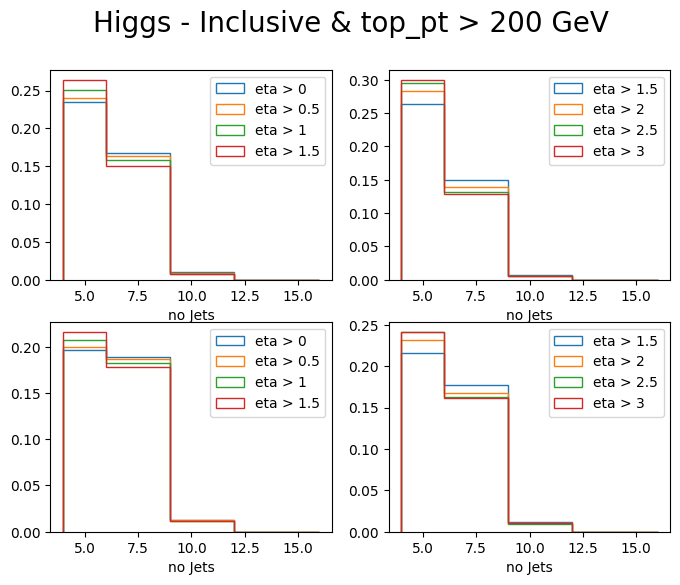

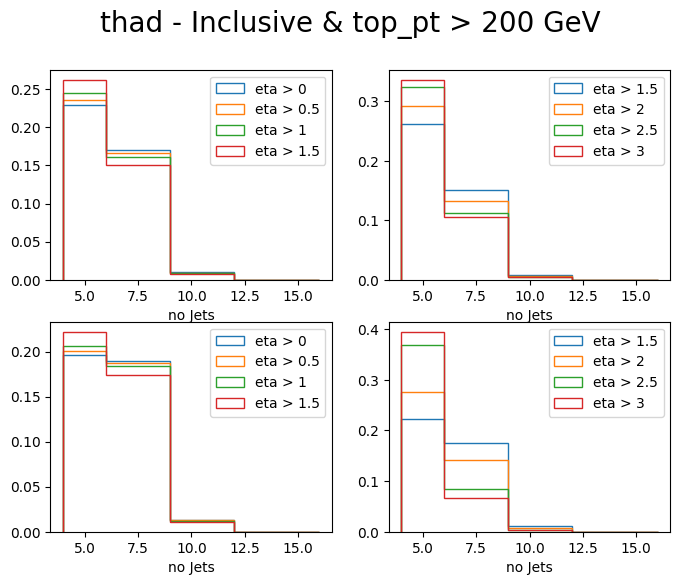

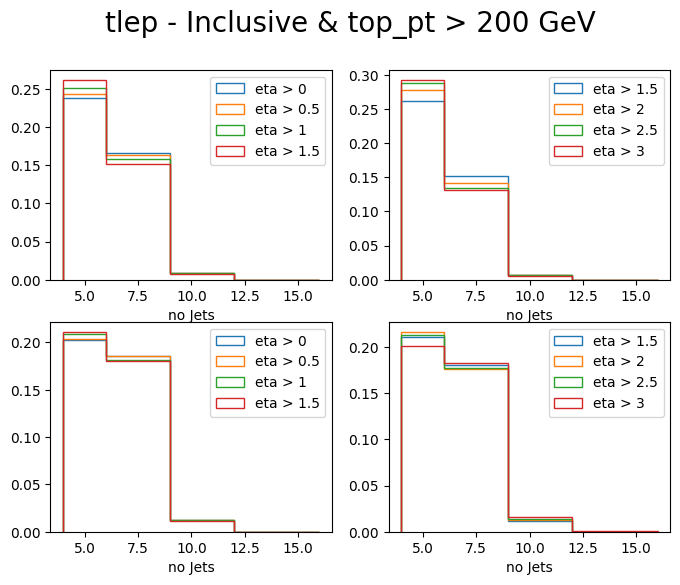

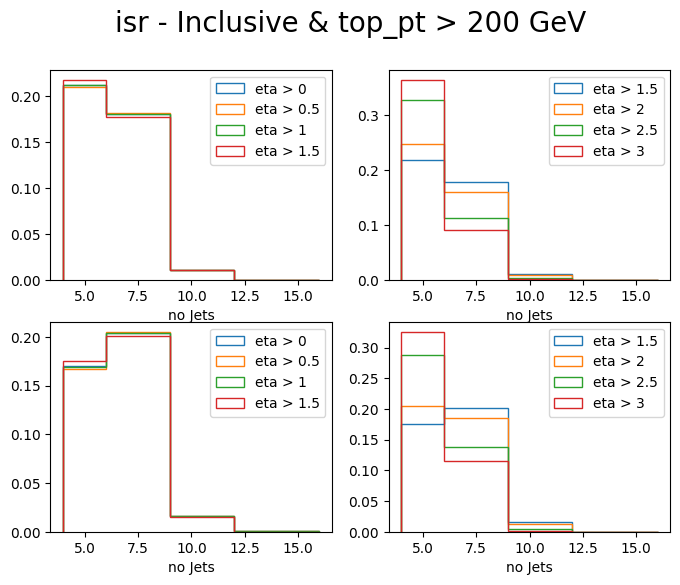

In [19]:
particles = ['Higgs', 'thad', 'tlep', 'isr']
no_plots = int(len(pt_bins)/4)
print(len(pt_bins))
eta_bins = [0,0.5,1,1.5,2,2.5,3,5]

events_HiggsPtLarger200 = partons[:,1,0] > 200

# particle pt
for particle in range(4):

    fig, ax = plt.subplots(2, no_plots, figsize=(8, 6))
    fig.suptitle(f'{particles[particle]} - Inclusive & top_pt > 200 GeV', fontsize=20)

    particle_eta = torch.abs(partons[:,particle,1])
    for i in range(4):
        mask_1 = particle_eta > eta_bins[i]
        mask_2 = particle_eta < eta_bins[i + 1]
        mask = torch.logical_and(mask_1, mask_2)
        ax[0,0].hist(noJets[mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label=f'eta > {eta_bins[i]}')
        
        # AND between mask And central events
        mask = torch.logical_and(mask, events_HiggsPtLarger200)
        ax[1,0].hist(noJets[mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label=f'eta > {eta_bins[i]}')

    ax[0,0].set_xlabel('no Jets')
    ax[0,0].legend()
    ax[1,0].set_xlabel('no Jets')
    ax[1,0].legend()

    last_var = i
    for i in range(4):
        mask_1 = particle_eta > eta_bins[last_var + i]
        mask_2 = particle_eta < eta_bins[last_var + i + 1]
        mask = torch.logical_and(mask_1, mask_2)
        ax[0,1].hist(noJets[mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label=f'eta > {eta_bins[last_var + i]}')
        
        # AND between mask And central events
        mask = torch.logical_and(mask, events_HiggsPtLarger200)
        ax[1,1].hist(noJets[mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label=f'eta > {eta_bins[last_var + i]}')

    ax[0,1].set_xlabel('no Jets')
    ax[0,1].legend()
    ax[1,1].set_xlabel('no Jets')
    ax[1,1].legend()

9


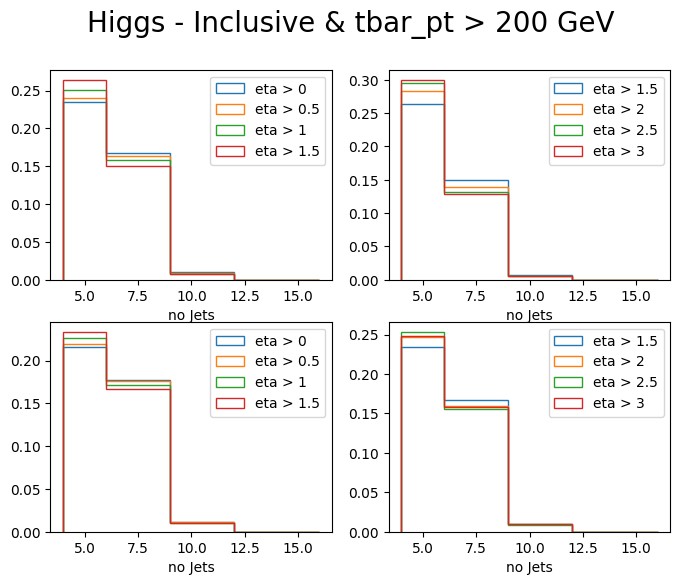

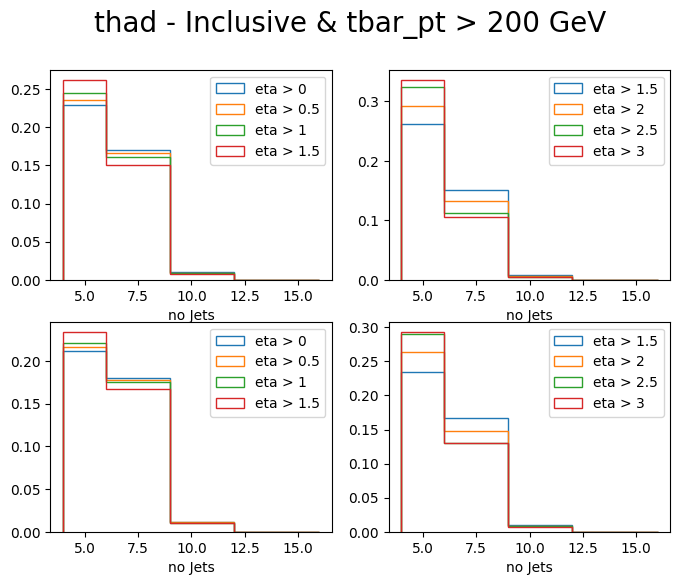

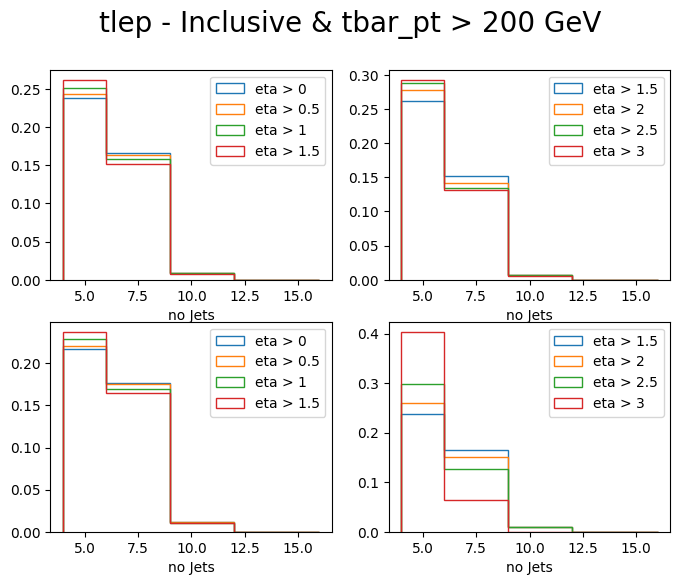

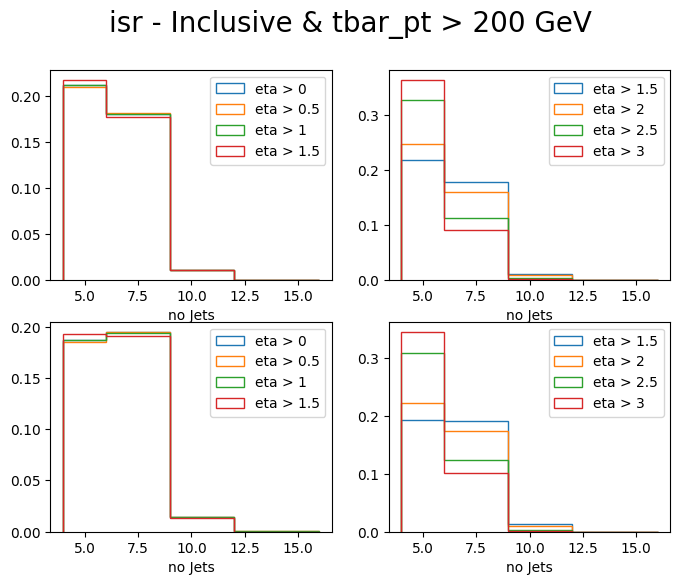

In [20]:
particles = ['Higgs', 'thad', 'tlep', 'isr']
no_plots = int(len(pt_bins)/4)
print(len(pt_bins))
eta_bins = [0,0.5,1,1.5,2,2.5,3,5]

events_HiggsPtLarger200 = partons[:,2,0] > 200

# particle pt
for particle in range(4):

    fig, ax = plt.subplots(2, no_plots, figsize=(8, 6))
    fig.suptitle(f'{particles[particle]} - Inclusive & tbar_pt > 200 GeV', fontsize=20)

    particle_eta = torch.abs(partons[:,particle,1])
    for i in range(4):
        mask_1 = particle_eta > eta_bins[i]
        mask_2 = particle_eta < eta_bins[i + 1]
        mask = torch.logical_and(mask_1, mask_2)
        ax[0,0].hist(noJets[mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label=f'eta > {eta_bins[i]}')
        
        # AND between mask And central events
        mask = torch.logical_and(mask, events_HiggsPtLarger200)
        ax[1,0].hist(noJets[mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label=f'eta > {eta_bins[i]}')

    ax[0,0].set_xlabel('no Jets')
    ax[0,0].legend()
    ax[1,0].set_xlabel('no Jets')
    ax[1,0].legend()

    last_var = i
    for i in range(4):
        mask_1 = particle_eta > eta_bins[last_var + i]
        mask_2 = particle_eta < eta_bins[last_var + i + 1]
        mask = torch.logical_and(mask_1, mask_2)
        ax[0,1].hist(noJets[mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label=f'eta > {eta_bins[last_var + i]}')
        
        # AND between mask And central events
        mask = torch.logical_and(mask, events_HiggsPtLarger200)
        ax[1,1].hist(noJets[mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label=f'eta > {eta_bins[last_var + i]}')

    ax[0,1].set_xlabel('no Jets')
    ax[0,1].legend()
    ax[1,1].set_xlabel('no Jets')
    ax[1,1].legend()

9


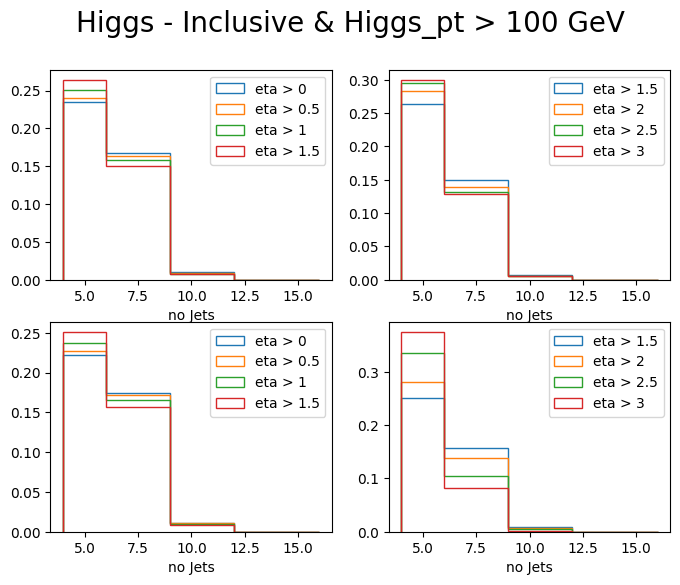

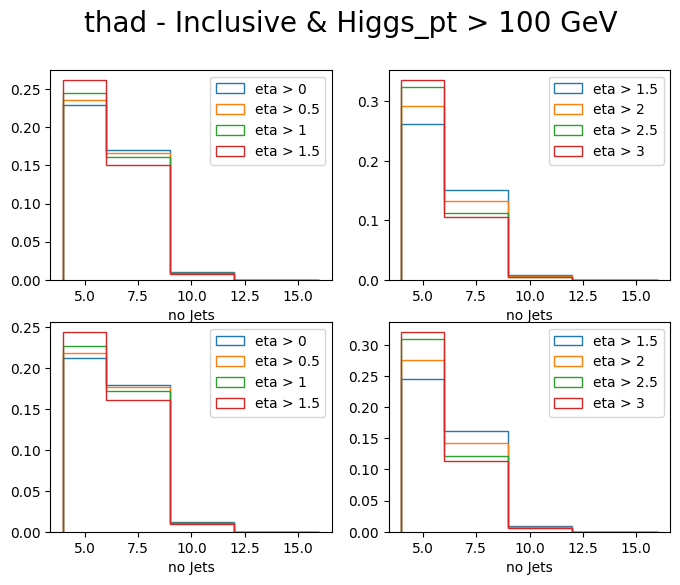

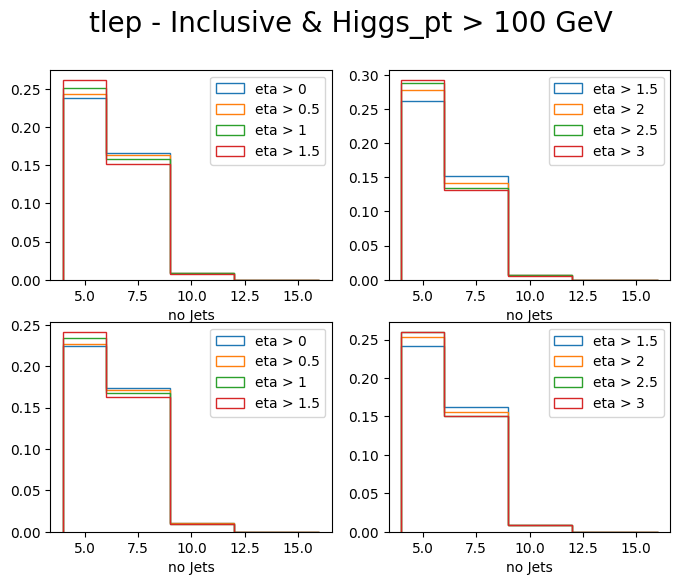

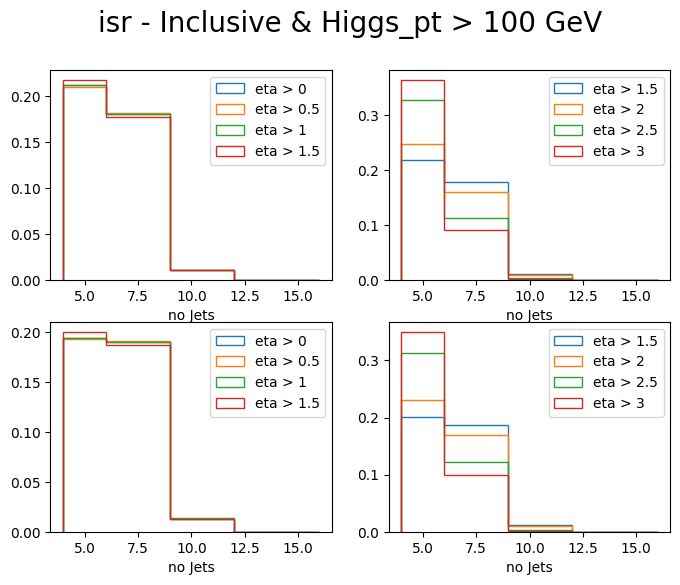

In [21]:
particles = ['Higgs', 'thad', 'tlep', 'isr']
no_plots = int(len(pt_bins)/4)
print(len(pt_bins))
eta_bins = [0,0.5,1,1.5,2,2.5,3,5]

events_HiggsPtLarger200 = partons[:,0,0] > 100

# particle pt
for particle in range(4):

    fig, ax = plt.subplots(2, no_plots, figsize=(8, 6))
    fig.suptitle(f'{particles[particle]} - Inclusive & Higgs_pt > 100 GeV', fontsize=20)

    particle_eta = torch.abs(partons[:,particle,1])
    for i in range(4):
        mask_1 = particle_eta > eta_bins[i]
        mask_2 = particle_eta < eta_bins[i + 1]
        mask = torch.logical_and(mask_1, mask_2)
        ax[0,0].hist(noJets[mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label=f'eta > {eta_bins[i]}')
        
        # AND between mask And central events
        mask = torch.logical_and(mask, events_HiggsPtLarger200)
        ax[1,0].hist(noJets[mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label=f'eta > {eta_bins[i]}')

    ax[0,0].set_xlabel('no Jets')
    ax[0,0].legend()
    ax[1,0].set_xlabel('no Jets')
    ax[1,0].legend()

    last_var = i
    for i in range(4):
        mask_1 = particle_eta > eta_bins[last_var + i]
        mask_2 = particle_eta < eta_bins[last_var + i + 1]
        mask = torch.logical_and(mask_1, mask_2)
        ax[0,1].hist(noJets[mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label=f'eta > {eta_bins[last_var + i]}')
        
        # AND between mask And central events
        mask = torch.logical_and(mask, events_HiggsPtLarger200)
        ax[1,1].hist(noJets[mask].cpu().numpy(), bins=noJets_bins, density=True, histtype='step', label=f'eta > {eta_bins[last_var + i]}')

    ax[0,1].set_xlabel('no Jets')
    ax[0,1].legend()
    ax[1,1].set_xlabel('no Jets')
    ax[1,1].legend()

# check how pt_higgs use for different no ef events: 

torch.Size([1612912])
torch.Size([1612912, 4, 4])


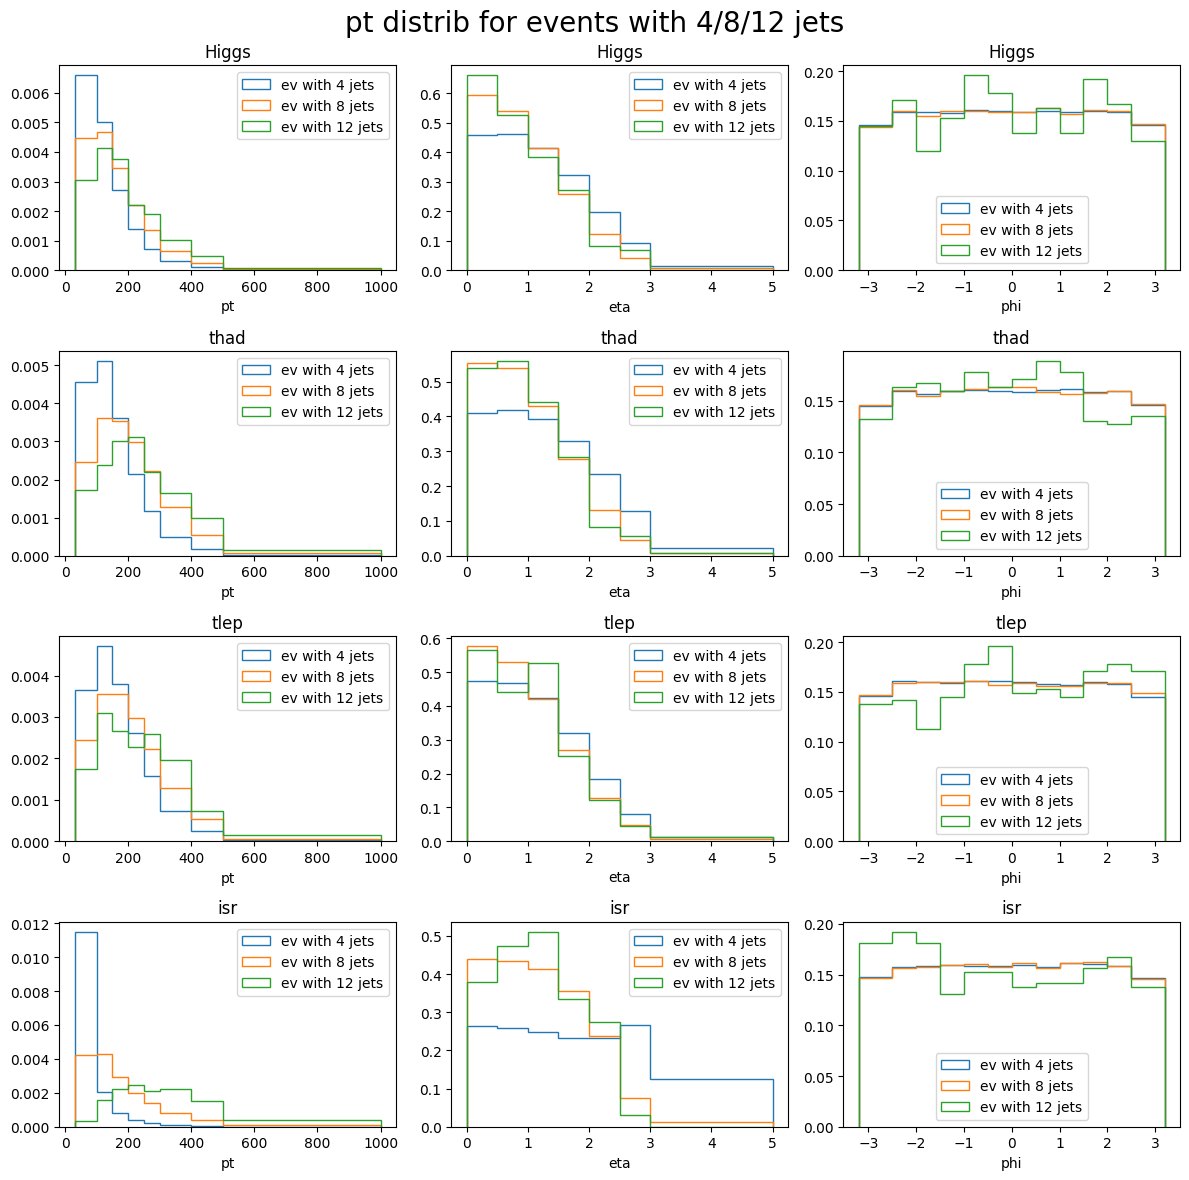

In [22]:
# start with 4 vs 8 vs 12

print(noJets.shape)
print(partons.shape)

events_4jets = noJets == 4
events_8jets = noJets == 8
events_12jets = noJets == 12

particles = ['Higgs', 'thad', 'tlep', 'isr']
no_plots = int(len(pt_bins)/4)
pt_bins = [30,100,150,200,250,300,400,500,1000]
features = ['pt','eta','phi']

fig, ax = plt.subplots(4, 3, figsize=(12, 12))
fig.suptitle(f'pt distrib for events with 4/8/12 jets', fontsize=20)

# particle pt
for particle in range(4):
    
    for feature in range(3):
        
        if feature == 0:
            bins = pt_bins
        elif feature == 1:
            bins = eta_bins
        else:
            bins = phi_bins
            
        particle_pt = partons[:,particle,feature]
        ax[particle,feature].hist(particle_pt[events_4jets].cpu().numpy(), bins=bins, density=True, histtype='step', label=f'ev with 4 jets')
        ax[particle,feature].hist(particle_pt[events_8jets].cpu().numpy(), bins=bins, density=True, histtype='step', label=f'ev with 8 jets')
        ax[particle,feature].hist(particle_pt[events_12jets].cpu().numpy(), bins=bins, density=True, histtype='step', label=f'ev with 12 jets')

        ax[particle,feature].set_xlabel(features[feature])
        ax[particle,feature].legend(fontsize=10)
        ax[particle,feature].set_title(particles[particle])
    
plt.tight_layout()

# New plots: dependency on HT and avg(eta)

In [23]:
HT = partons[:,0,0] + partons[:,1,0] + partons[:,2,0] + partons[:,3,0]
total_eta = partons[:,0,1] + partons[:,1,1] + partons[:,2,1] + partons[:,3,1]
total_abs_eta = torch.abs(partons[:,0,1]) + torch.abs(partons[:,1,1]) + torch.abs(partons[:,2,1]) + torch.abs(partons[:,3,1])

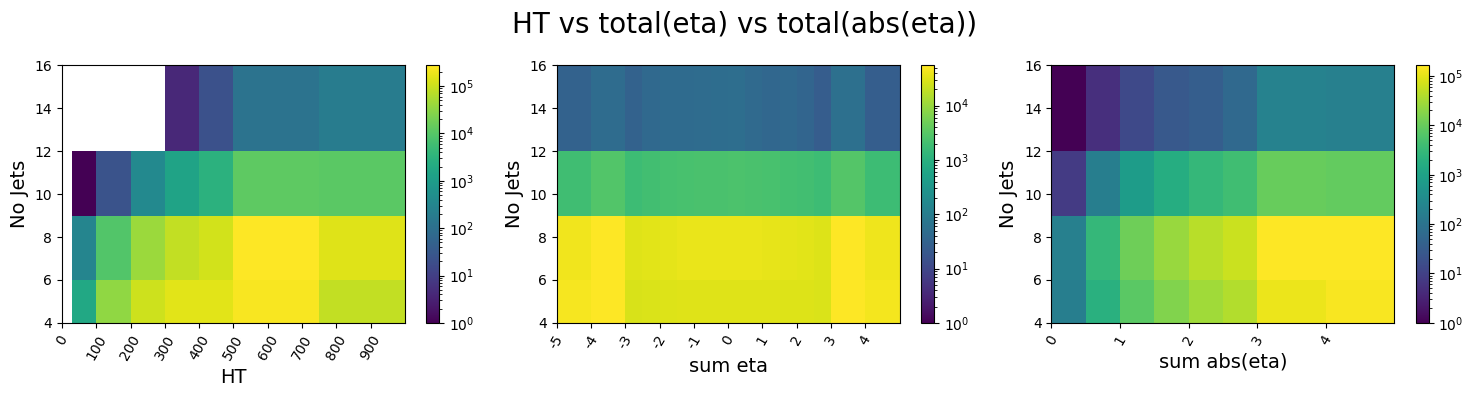

In [31]:
pt_bins = [30,100,200,300,400,500,750,1000]
eta_bins = [-5,-4,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,4,5]
eta_bins2 = [0,0.5,1,1.5,2,2.5,3,4,5]

labels = ['HT', 'sum eta', 'sum abs(eta)']
colormap='viridis'
my_viridis = mpl.colormaps[colormap].with_extremes(under="white")

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('HT vs total(eta) vs total(abs(eta))', fontsize=20)

for plot in range(3):
    if plot == 0:
        bins = pt_bins
        start = 0
        end = 1000
        step = 100
        var = HT
    else:
        bins = eta_bins
        start = -5
        end = 5
        step = 1
        if plot == 1:
            var = total_eta
        else:
            start = 0
            var = total_abs_eta
            bins = eta_bins2
        
    hist = ax[plot].hist2d(var.cpu().numpy(),
                            noJets.cpu().numpy(), bins=[bins, noJets_bins],
                            norm=mpl.colors.LogNorm(vmin=1), cmap=my_viridis)

    cb1=plt.colorbar(hist[3], ax=ax[plot])

    #ax[0, plot].set_title(f'titlu', fontsize=10)
    ax[plot].set_xlabel(labels[plot], fontsize=14)
    ax[plot].set_ylabel('No Jets', fontsize=14)

    ax[plot].set_xticks(np.arange(start, end, step))
    ax[plot].set_xticklabels(ax[plot].get_xticks(), rotation=60)
    
plt.tight_layout()

# look inside awkward

In [9]:
print(path_data)

/eos/user/a/adpetre/www/ttHbbAnalysis/training_dataset/v3_sig_forTrainingDataset/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_train.parquet


In [10]:
df = ak.from_parquet(path_data)
df.type

ArrayType(RecordType([ListType(OptionType(RecordType([NumpyType('float64'), NumpyType('float64'), NumpyType('float64'), NumpyType('float64'), NumpyType('float64'), NumpyType('float64')], ['pt', 'eta', 'phi', 'mass', 'pdgId', 'prov']))), ListType(RecordType([NumpyType('float64'), NumpyType('float64'), NumpyType('float64'), NumpyType('float64'), NumpyType('float64'), NumpyType('float64')], ['pt', 'eta', 'phi', 'mass', 'pdgId', 'prov'])), RecordType([NumpyType('int32'), NumpyType('int32'), NumpyType('float32'), NumpyType('float32')], ['pdgid1', 'pdgid2', 'x1', 'x2']), ListType(RecordType([NumpyType('float32'), NumpyType('float32'), NumpyType('float32'), NumpyType('float32'), NumpyType('int32')], ['pt', 'eta', 'phi', 'mass', 'pdgId'])), ListType(RecordType([NumpyType('float32'), NumpyType('float32'), NumpyType('float32'), NumpyType('float32')], ['pt', 'eta', 'phi', 'm'])), RecordType([NumpyType('float32'), NumpyType('float32'), NumpyType('float32'), NumpyType('float32')], ['pt', 'eta', 'ph

In [11]:
(partons_matched,
partons,
generator_info,
lepton_partons,
lepton_reco, 
met,
higgs,
weight,
prob_ak,
jets) = ak.unzip(df)

jets = ak.with_name(jets, name="Momentum4D")
partons_matched = ak.with_name(partons_matched, name="Momentum4D")
partons = ak.with_name(partons, name="Momentum4D")
lepton_partons = ak.with_name(lepton_partons, name="Momentum4D")
lepton_reco = ak.with_name(lepton_reco, name="Momentum4D")
met = ak.with_name(met, name="Momentum4D")
higgs = ak.with_name(higgs, name="Momentum4D")

In [12]:
print(partons_matched[0].type)
print(partons[0].type)
print(partons[0].pdgId)
print(partons[0].prov)

7 * ?Momentum4D[pt: float64, eta: float64, phi: float64, mass: float64, pdgId: float64, prov: float64]
7 * Momentum4D[pt: float64, eta: float64, phi: float64, mass: float64, pdgId: float64, prov: float64]
[21, 5, -5, 3, -4, 5, -5]
[4, 3, 2, 5, 5, 1, 1]


[7, 4, 6, 5, 10, 6, 6, 5, 6, 6, 7, 6, ..., 7, 5, 4, 5, 5, 6, 4, 9, 5, 6, 5, 5]
[False, False, False, True, False, False, ..., False, True, False, True, True]
[2 1 2 ... 1 2 2]
[1 1 1 ... 1 0 1]


Text(0.5, 1.0, 'Events with 5 jets')

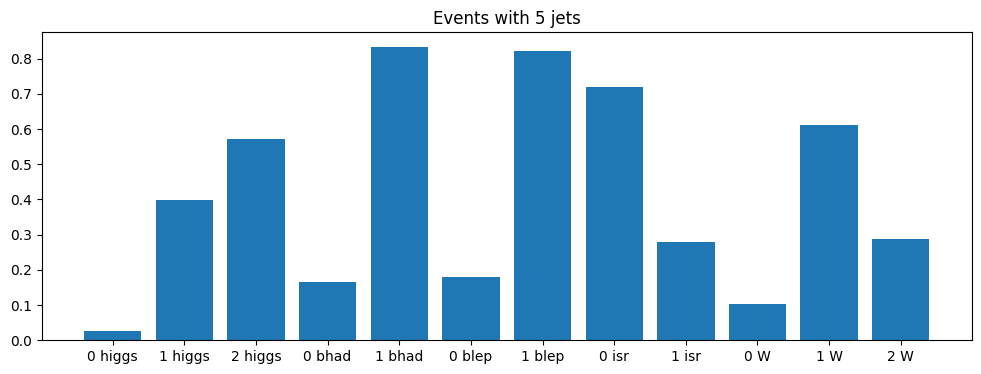

In [13]:
noJetsPerEvent = ak.count(jets, axis=1)
print(noJetsPerEvent)

less6jets = noJetsPerEvent == 5
print(less6jets)

events_less6jets = jets[less6jets]
higgs_jets = events_less6jets.prov == 1
bhad_jets = events_less6jets.prov == 2
blep_jets = events_less6jets.prov == 3
isr_jets = events_less6jets.prov == 4
W_jets = events_less6jets.prov == 5

count_higgs = ak.to_numpy(ak.count_nonzero(higgs_jets, axis=1), allow_missing=False)
count_bhad = ak.to_numpy(ak.count_nonzero(bhad_jets, axis=1), allow_missing=False)
count_blep = ak.to_numpy(ak.count_nonzero(blep_jets, axis=1), allow_missing=False)
count_isr = ak.to_numpy(ak.count_nonzero(isr_jets, axis=1), allow_missing=False)
count_WJets = ak.to_numpy(ak.count_nonzero(W_jets, axis=1), allow_missing=False)

print(count_higgs)
print(count_bhad)

a0_higgs = np.count_nonzero(count_higgs == 0)/len(events_less6jets)
a1_higgs = np.count_nonzero(count_higgs == 1)/len(events_less6jets)
a2_higgs = np.count_nonzero(count_higgs == 2)/len(events_less6jets)

a0_bhad = np.count_nonzero(count_bhad == 0)/len(events_less6jets)
a1_bhad = np.count_nonzero(count_bhad == 1)/len(events_less6jets)

a0_blep = np.count_nonzero(count_blep == 0)/len(events_less6jets)
a1_blep = np.count_nonzero(count_blep == 1)/len(events_less6jets)

a0_isr = np.count_nonzero(count_isr == 0)/len(events_less6jets)
a1_isr = np.count_nonzero(count_isr == 1)/len(events_less6jets)

a0_WJets = np.count_nonzero(count_WJets == 0)/len(events_less6jets)
a1_WJets = np.count_nonzero(count_WJets == 1)/len(events_less6jets)
a2_WJets = np.count_nonzero(count_WJets == 2)/len(events_less6jets)

x_axis = ['0 higgs', '1 higgs', '2 higgs', '0 bhad', '1 bhad', '0 blep', '1 blep',  '0 isr', '1 isr', '0 W', '1 W', '2 W']
y_axis = [a0_higgs, a1_higgs, a2_higgs, a0_bhad, a1_bhad, a0_blep, a1_blep, a0_isr, a1_isr, a0_WJets, a1_WJets, a2_WJets]

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(x_axis, y_axis)
ax.set_title('Events with 5 jets')

[7, 4, 6, 5, 10, 6, 6, 5, 6, 6, 7, 6, ..., 7, 5, 4, 5, 5, 6, 4, 9, 5, 6, 5, 5]
[False, True, False, False, False, ..., False, False, False, False, False]
[2 1 1 ... 2 2 1]
[0 1 1 ... 1 1 1]


Text(0.5, 1.0, 'Events with 4 jets')

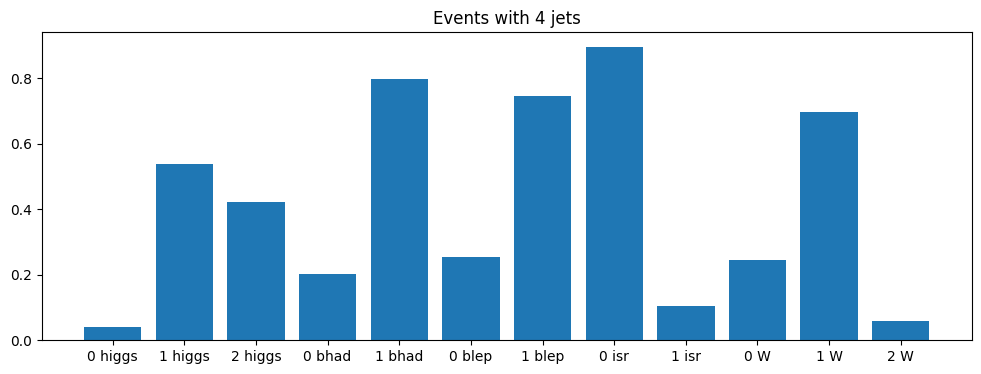

In [14]:
noJetsPerEvent = ak.count(jets, axis=1)
print(noJetsPerEvent)

less6jets = noJetsPerEvent == 4
print(less6jets)

events_less6jets = jets[less6jets]
higgs_jets = events_less6jets.prov == 1
bhad_jets = events_less6jets.prov == 2
blep_jets = events_less6jets.prov == 3
isr_jets = events_less6jets.prov == 4
W_jets = events_less6jets.prov == 5

count_higgs = ak.to_numpy(ak.count_nonzero(higgs_jets, axis=1), allow_missing=False)
count_bhad = ak.to_numpy(ak.count_nonzero(bhad_jets, axis=1), allow_missing=False)
count_blep = ak.to_numpy(ak.count_nonzero(blep_jets, axis=1), allow_missing=False)
count_isr = ak.to_numpy(ak.count_nonzero(isr_jets, axis=1), allow_missing=False)
count_WJets = ak.to_numpy(ak.count_nonzero(W_jets, axis=1), allow_missing=False)

print(count_higgs)
print(count_bhad)

a0_higgs = np.count_nonzero(count_higgs == 0)/len(events_less6jets)
a1_higgs = np.count_nonzero(count_higgs == 1)/len(events_less6jets)
a2_higgs = np.count_nonzero(count_higgs == 2)/len(events_less6jets)

a0_bhad = np.count_nonzero(count_bhad == 0)/len(events_less6jets)
a1_bhad = np.count_nonzero(count_bhad == 1)/len(events_less6jets)

a0_blep = np.count_nonzero(count_blep == 0)/len(events_less6jets)
a1_blep = np.count_nonzero(count_blep == 1)/len(events_less6jets)

a0_isr = np.count_nonzero(count_isr == 0)/len(events_less6jets)
a1_isr = np.count_nonzero(count_isr == 1)/len(events_less6jets)

a0_WJets = np.count_nonzero(count_WJets == 0)/len(events_less6jets)
a1_WJets = np.count_nonzero(count_WJets == 1)/len(events_less6jets)
a2_WJets = np.count_nonzero(count_WJets == 2)/len(events_less6jets)

x_axis = ['0 higgs', '1 higgs', '2 higgs', '0 bhad', '1 bhad', '0 blep', '1 blep',  '0 isr', '1 isr', '0 W', '1 W', '2 W']
y_axis = [a0_higgs, a1_higgs, a2_higgs, a0_bhad, a1_bhad, a0_blep, a1_blep, a0_isr, a1_isr, a0_WJets, a1_WJets, a2_WJets]

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(x_axis, y_axis)
ax.set_title('Events with 4 jets')

[7, 4, 6, 5, 10, 6, 6, 5, 6, 6, 7, 6, ..., 7, 5, 4, 5, 5, 6, 4, 9, 5, 6, 5, 5]
[False, False, True, False, False, True, ..., False, False, True, False, False]
[2 0 1 ... 2 1 2]
[1 0 0 ... 1 1 1]


Text(0.5, 1.0, 'Events with 6 jets')

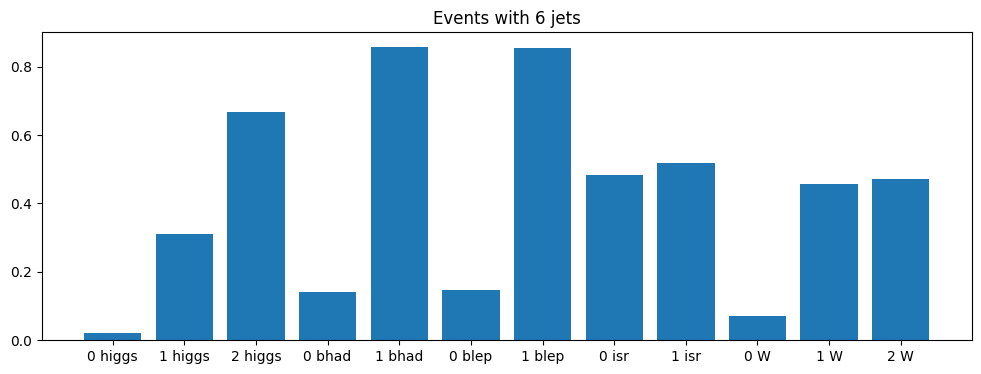

In [15]:
noJetsPerEvent = ak.count(jets, axis=1)
print(noJetsPerEvent)

less6jets = noJetsPerEvent == 6
print(less6jets)

events_less6jets = jets[less6jets]
higgs_jets = events_less6jets.prov == 1
bhad_jets = events_less6jets.prov == 2
blep_jets = events_less6jets.prov == 3
isr_jets = events_less6jets.prov == 4
W_jets = events_less6jets.prov == 5

count_higgs = ak.to_numpy(ak.count_nonzero(higgs_jets, axis=1), allow_missing=False)
count_bhad = ak.to_numpy(ak.count_nonzero(bhad_jets, axis=1), allow_missing=False)
count_blep = ak.to_numpy(ak.count_nonzero(blep_jets, axis=1), allow_missing=False)
count_isr = ak.to_numpy(ak.count_nonzero(isr_jets, axis=1), allow_missing=False)
count_WJets = ak.to_numpy(ak.count_nonzero(W_jets, axis=1), allow_missing=False)

print(count_higgs)
print(count_bhad)

a0_higgs = np.count_nonzero(count_higgs == 0)/len(events_less6jets)
a1_higgs = np.count_nonzero(count_higgs == 1)/len(events_less6jets)
a2_higgs = np.count_nonzero(count_higgs == 2)/len(events_less6jets)

a0_bhad = np.count_nonzero(count_bhad == 0)/len(events_less6jets)
a1_bhad = np.count_nonzero(count_bhad == 1)/len(events_less6jets)

a0_blep = np.count_nonzero(count_blep == 0)/len(events_less6jets)
a1_blep = np.count_nonzero(count_blep == 1)/len(events_less6jets)

a0_isr = np.count_nonzero(count_isr == 0)/len(events_less6jets)
a1_isr = np.count_nonzero(count_isr == 1)/len(events_less6jets)

a0_WJets = np.count_nonzero(count_WJets == 0)/len(events_less6jets)
a1_WJets = np.count_nonzero(count_WJets == 1)/len(events_less6jets)
a2_WJets = np.count_nonzero(count_WJets == 2)/len(events_less6jets)

x_axis = ['0 higgs', '1 higgs', '2 higgs', '0 bhad', '1 bhad', '0 blep', '1 blep',  '0 isr', '1 isr', '0 W', '1 W', '2 W']
y_axis = [a0_higgs, a1_higgs, a2_higgs, a0_bhad, a1_bhad, a0_blep, a1_blep, a0_isr, a1_isr, a0_WJets, a1_WJets, a2_WJets]

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(x_axis, y_axis)
ax.set_title('Events with 6 jets')

In [16]:
def compute_prob_eachNoMatchedJets(jet_tensor, no_jets):

    noJetsPerEvent = ak.count(jet_tensor, axis=1)
    Xjets = noJetsPerEvent == no_jets

    events_Xjets = jets[Xjets]
    higgs_jets = events_Xjets.prov == 1
    bhad_jets = events_Xjets.prov == 2
    blep_jets = events_Xjets.prov == 3
    isr_jets = events_Xjets.prov == 4
    W_jets = events_Xjets.prov == 5

    count_higgs = ak.to_numpy(ak.count_nonzero(higgs_jets, axis=1), allow_missing=False)
    count_bhad = ak.to_numpy(ak.count_nonzero(bhad_jets, axis=1), allow_missing=False)
    count_blep = ak.to_numpy(ak.count_nonzero(blep_jets, axis=1), allow_missing=False)
    count_isr = ak.to_numpy(ak.count_nonzero(isr_jets, axis=1), allow_missing=False)
    count_WJets = ak.to_numpy(ak.count_nonzero(W_jets, axis=1), allow_missing=False)

    a0_higgs = np.count_nonzero(count_higgs == 0)/len(events_Xjets)
    a1_higgs = np.count_nonzero(count_higgs == 1)/len(events_Xjets)
    a2_higgs = np.count_nonzero(count_higgs == 2)/len(events_Xjets)

    a0_bhad = np.count_nonzero(count_bhad == 0)/len(events_Xjets)
    a1_bhad = np.count_nonzero(count_bhad == 1)/len(events_Xjets)

    a0_blep = np.count_nonzero(count_blep == 0)/len(events_Xjets)
    a1_blep = np.count_nonzero(count_blep == 1)/len(events_Xjets)

    a0_isr = np.count_nonzero(count_isr == 0)/len(events_Xjets)
    a1_isr = np.count_nonzero(count_isr == 1)/len(events_Xjets)

    a0_WJets = np.count_nonzero(count_WJets == 0)/len(events_Xjets)
    a1_WJets = np.count_nonzero(count_WJets == 1)/len(events_Xjets)
    a2_WJets = np.count_nonzero(count_WJets == 2)/len(events_Xjets)

    probabilities = torch.tensor([a0_higgs, a1_higgs, a2_higgs, a0_bhad, a1_bhad, a0_blep, a1_blep, a0_isr, a1_isr, a0_WJets, a1_WJets, a2_WJets])
    
    return probabilities



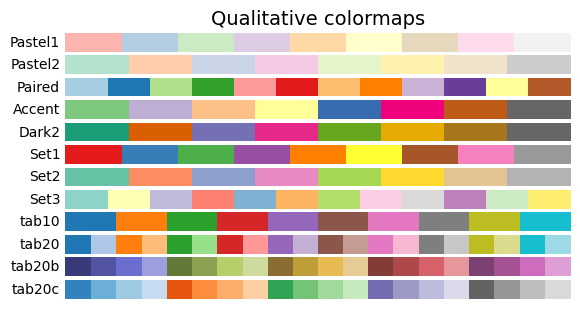

In [17]:
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=mpl.colormaps[name])
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list

plot_color_gradients('Qualitative',
                     ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2',
                      'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b',
                      'tab20c'])

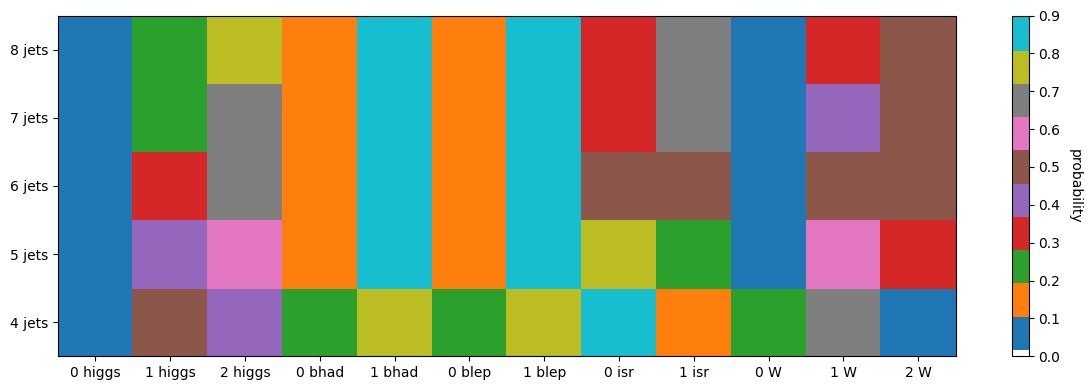

In [18]:
prob_tensor = torch.zeros((5, 12))
for i in range(5):
    prob_tensor[i] = compute_prob_eachNoMatchedJets(jet_tensor=jets, no_jets=i+4)

cmap = plt.cm.tab10

fig, ax = plt.subplots(figsize=(12, 4))
heatmap = ax.pcolor(prob_tensor, cmap=cmap)

#legend
cbar = plt.colorbar(heatmap)

cbar.ax.get_yaxis().set_ticks(0.1*np.arange(10))
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('probability', rotation=270)


# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(prob_tensor.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(prob_tensor.shape[0]) + 0.5, minor=False)
#print(ax.get_xticks())
#ax.invert_yaxis()

#labels
column_labels = ['4 jets', '5 jets', '6 jets', '7 jets', '8 jets']
row_labels = ['0 higgs', '1 higgs', '2 higgs', '0 bhad', '1 bhad', '0 blep', '1 blep',  '0 isr', '1 isr', '0 W', '1 W', '2 W']
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels, minor=False)

plt.tight_layout()
#plt.show()

In [19]:
# cross prob -> events with 6 jets; 
# put the cross product of these columns

# Cross correlation matrix

In [20]:
def compute_prob_eachNoMatchedJets(jet_tensor, event_no_jets, case, case_no_jets):

    noJetsPerEvent = ak.count(jet_tensor, axis=1)
    Xjets = noJetsPerEvent == event_no_jets

    events_Xjets = jets[Xjets]
    higgs_jets = ak.to_numpy(events_Xjets.prov == 1, allow_missing=False)
    bhad_jets = ak.to_numpy(events_Xjets.prov == 2, allow_missing=False)
    blep_jets = ak.to_numpy(events_Xjets.prov == 3, allow_missing=False)
    isr_jets = ak.to_numpy(events_Xjets.prov == 4, allow_missing=False)
    W_jets = ak.to_numpy(events_Xjets.prov == 5, allow_missing=False)
    
    events_cut = np.count_nonzero(eval(case + '_jets'), axis=1) == case_no_jets # mask of events
    events_Xjets = events_Xjets[events_cut]
    
    higgs_jets = higgs_jets[events_cut]
    bhad_jets = bhad_jets[events_cut]
    blep_jets = blep_jets[events_cut]
    isr_jets = isr_jets[events_cut]
    W_jets = W_jets[events_cut]
    
    count_higgs = ak.to_numpy(ak.count_nonzero(higgs_jets, axis=1), allow_missing=False)
    count_bhad = ak.to_numpy(ak.count_nonzero(bhad_jets, axis=1), allow_missing=False)
    count_blep = ak.to_numpy(ak.count_nonzero(blep_jets, axis=1), allow_missing=False)
    count_isr = ak.to_numpy(ak.count_nonzero(isr_jets, axis=1), allow_missing=False)
    count_WJets = ak.to_numpy(ak.count_nonzero(W_jets, axis=1), allow_missing=False)
    
    a0_higgs = np.count_nonzero(count_higgs == 0)/len(events_Xjets)
    a1_higgs = np.count_nonzero(count_higgs == 1)/len(events_Xjets)
    a2_higgs = np.count_nonzero(count_higgs == 2)/len(events_Xjets)

    a0_bhad = np.count_nonzero(count_bhad == 0)/len(events_Xjets)
    a1_bhad = np.count_nonzero(count_bhad == 1)/len(events_Xjets)

    a0_blep = np.count_nonzero(count_blep == 0)/len(events_Xjets)
    a1_blep = np.count_nonzero(count_blep == 1)/len(events_Xjets)

    a0_isr = np.count_nonzero(count_isr == 0)/len(events_Xjets)
    a1_isr = np.count_nonzero(count_isr == 1)/len(events_Xjets)

    a0_WJets = np.count_nonzero(count_WJets == 0)/len(events_Xjets)
    a1_WJets = np.count_nonzero(count_WJets == 1)/len(events_Xjets)
    a2_WJets = np.count_nonzero(count_WJets == 2)/len(events_Xjets)

    probabilities = torch.tensor([a0_higgs, a1_higgs, a2_higgs, a0_bhad, a1_bhad, a0_blep, a1_blep, a0_isr, a1_isr, a0_WJets, a1_WJets, a2_WJets])
    
    return probabilities



In [22]:
event_no_jets=4
cross_matrix = torch.zeros((12,12))

for i in range(12):
    if i == 0 or i == 3 or i == 5 or i == 7 or i == 9:
        case_no_jets = 0
        
    if i < 3:
        case = 'higgs'
    elif i < 5:
        case = 'bhad'
    elif i < 7:
        case = 'blep'
    elif i < 9:
        case = 'isr'
    else:
        case = 'W'
        
    print(f'case: {case} and no_jets: {case_no_jets}')
        
    cross_matrix[i] = compute_prob_eachNoMatchedJets(jet_tensor=jets, event_no_jets=event_no_jets, case=case, case_no_jets=case_no_jets)
    case_no_jets = case_no_jets+1

print(cross_matrix.shape)
row_labels = ['0 higgs', '1 higgs', '2 higgs', '0 bhad', '1 bhad', '0 blep', '1 blep',  '0 isr', '1 isr', '0 W', '1 W', '2 W']
df = pd.DataFrame(cross_matrix, index=row_labels, columns=row_labels)

def make_pretty(styler):
    styler.set_caption(f"Cross correlation matrix: Events with {event_no_jets} jets")
    styler.background_gradient(axis=None, vmin=1, vmax=5, cmap="YlGnBu")
    return styler# create pivot table with x and rows, y and columns, z as values


df.style.pipe(make_pretty)

case: higgs and no_jets: 0
case: higgs and no_jets: 1
case: higgs and no_jets: 2
case: bhad and no_jets: 0
case: bhad and no_jets: 1
case: blep and no_jets: 0
case: blep and no_jets: 1
case: isr and no_jets: 0
case: isr and no_jets: 1
case: W and no_jets: 0
case: W and no_jets: 1
case: W and no_jets: 2
torch.Size([12, 12])


,0 higgs,1 higgs,2 higgs,0 bhad,1 bhad,0 blep,1 blep,0 isr,1 isr,0 W,1 W,2 W
0 higgs,1.000000,0.000000,0.000000,0.079165,0.920835,0.086013,0.913987,0.757662,0.242338,0.106221,0.617954,0.275825
1 higgs,0.000000,1.000000,0.000000,0.104752,0.895248,0.118364,0.881636,0.878140,0.121860,0.150626,0.774346,0.075028
2 higgs,0.000000,0.000000,1.000000,0.338572,0.661428,0.445670,0.554330,0.930319,0.069681,0.379003,0.605786,0.015211
0 bhad,0.016308,0.278393,0.705298,1.000000,0.000000,0.117031,0.882969,0.849561,0.150439,0.133305,0.718613,0.148082
1 bhad,0.048063,0.602830,0.349107,0.000000,1.000000,0.289768,0.710232,0.906633,0.093367,0.273236,0.691337,0.035427
0 blep,0.014055,0.249522,0.736423,0.092831,0.907169,1.000000,0.000000,0.844386,0.155614,0.146294,0.743546,0.110160
1 blep,0.051079,0.635649,0.313272,0.239539,0.760461,0.000000,1.000000,0.912439,0.087561,0.278690,0.680881,0.040430
0 isr,0.035250,0.527068,0.437683,0.191867,0.808133,0.240412,0.759588,1.000000,0.000000,0.199062,0.737571,0.063366
1 isr,0.096201,0.624080,0.279719,0.289896,0.710104,0.378042,0.621958,0.000000,1.000000,0.636478,0.349400,0.014122
0 W,0.018059,0.330366,0.651575,0.110013,0.889987,0.152207,0.847793,0.727416,0.272584,1.000000,0.000000,0.000000
